# Karen Ngugi - Intern ID 696532020

## Getting the Data

In [ ]:
# import basic Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import Twitter libraries
import tweepy
from tweepy import OAuthHandler

#sentiment analysis package
from textblob import TextBlob

#general text pre-processor
import nltk
# from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

#tweet pre-processor 
!pip install tweet-preprocessor
import preprocessor as p

# to view all columns
pd.set_option("display.max.columns", None)
pd.set_option('display.max.rows', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            
            #Variables that contains the user credentials to access Twitter API 
#             consumer_key = os.environ.get('TWITTER_API_KEY')
#             consumer_secret = os.environ.get('TWITTER_API_SECRET')
#             access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
#             access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
            
            consumer_key = ""
            consumer_secret = ""
            access_token = ""
            access_token_secret = ""
            
            #This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
            

        #            
        self.auth = auth
        self.api = tweepy.API(auth,wait_on_rate_limit=True) 
        self.filtered_tweet = ''
            

    def clean_tweets(self, twitter_text):

        #use pre processor
        tweet = p.clean(twitter_text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, keyword, csvfile=None):
        
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            

        #page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(self.api.search, q=keyword,count=100, include_rts=False,tweet_mode='extended').pages():

            # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
            for status in page:
                
                new_entry = []
                status = status._json
                
                #filter by language
                #if status['lang'] != 'en':
                #    continue

                
                #if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                filtered_tweet = self.clean_tweets(status['full_text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['full_text'], filtered_tweet, 
                              Sentiment,polarity,subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        #
#         df['timestamp'] = df.created_at.map(pd.Timestamp)
#         df = df.sort_values('timestamp').set_index('timestamp')
#         df = df.drop('id',axis=1)
        
        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, index=True, encoding="utf-8")
            

        return df

In [ ]:
users = pd.read_csv('influential_users_full.csv')
users_handles = users['handle'].to_list()
users_handles[:5]

['@gettleman', '@a24media', '@andiMakinana', '@AfricaCheck', '@JamesCopnall']

In [ ]:
gov = pd.read_csv('government_officials_full.csv')
gov.dropna(inplace = True)
gov_handles = gov['Handle'].to_list()
gov_handles[:5]

['@EswatiniGovern1',
 '@MalawiGovt',
 '@hagegeingob',
 '@FinanceSC',
 '@PresidencyZA']

In [ ]:
twitter_handles = users_handles + gov_handles
twitter_handles[:5]

['@gettleman', '@a24media', '@andiMakinana', '@AfricaCheck', '@JamesCopnall']

In [ ]:
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True) 

In [ ]:
# get list of available Twitter users
available_users = []
available_users_handles = []
for handle in twitter_handles:
    try:
        user = api.get_user('{}'.format(handle))
        available_users.append(user.name)
        available_users_handles.append('@{}'.format(user.screen_name))
    except:
        pass
    
len(available_users)

127

In [ ]:
users_bio = pd.DataFrame({
    'user' : available_users,
    'handle' : available_users_handles
})
users_bio.head()

,user,handle
0,Jeffrey Gettleman,@gettleman
1,A24 Media,@a24media
2,Scapegoat,@AndiMakinana
3,Africa Check,@AfricaCheck
4,James Copnall,@JamesCopnall


In [ ]:
# get number of their followers
followers_count = []
users_followers = []

for handle in available_users_handles:
    try:
        user = api.get_user('{}'.format(handle))
        users_followers.append(user.name)
        followers_count.append(user.followers_count)
    except:
        pass
    
len(followers_count)

127

In [ ]:
followers = pd.DataFrame({
    'user' : users_followers,
    'followers' : followers_count
})
followers.head()

,user,followers
0,Jeffrey Gettleman,25702
1,A24 Media,31286
2,Scapegoat,101294
3,Africa Check,68074
4,James Copnall,21962


In [ ]:
users_bio = pd.merge(users_bio, followers, on = "user")
users_bio.head()

,user,handle,followers
0,Jeffrey Gettleman,@gettleman,25702
1,A24 Media,@a24media,31286
2,Scapegoat,@AndiMakinana,101294
3,Africa Check,@AfricaCheck,68074
4,James Copnall,@JamesCopnall,21962


In [ ]:
# get number of people they're following
following_count = []
users_following = []

for handle in available_users_handles:
    try:
        user = api.get_user('{}'.format(handle))
        users_following.append(user.name)
        following_count.append(user.friends_count)
    except:
        pass

len(following_count)

127

In [ ]:
following = pd.DataFrame({
    'user' : users_following,
    'following' : following_count
})
following.head()

,user,following
0,Jeffrey Gettleman,37
1,A24 Media,3059
2,Scapegoat,2838
3,Africa Check,4592
4,James Copnall,5049


In [ ]:
users_bio = pd.merge(users_bio, following, on = "user")
users_bio.head()

,user,handle,followers,following
0,Jeffrey Gettleman,@gettleman,25702,37
1,A24 Media,@a24media,31286,3059
2,Scapegoat,@AndiMakinana,101294,2838
3,Africa Check,@AfricaCheck,68074,4592
4,James Copnall,@JamesCopnall,21962,5049


In [ ]:
# calculating reach score
users_bio['reach_score'] = users_bio['followers'] - users_bio['following']
users_bio.head()

,user,handle,followers,following,reach_score
0,Jeffrey Gettleman,@gettleman,25702,37,25665
1,A24 Media,@a24media,31286,3059,28227
2,Scapegoat,@AndiMakinana,101294,2838,98456
3,Africa Check,@AfricaCheck,68074,4592,63482
4,James Copnall,@JamesCopnall,21962,5049,16913


In [ ]:
# save to CSV file
users_bio.to_csv('users_bio.csv', index = False)

In [ ]:
# get 50 tweets per user
all_tweets = []

for handle in available_users_handles:
    try:
      all_tweets.extend(api.user_timeline(screen_name = "{}".format(handle),
                                        count = 50))
    except:
      pass

len(all_tweets)

6003

In [ ]:
# get necessary tweets information
tweets_info = [[tweet.user.name, tweet.text, 
               tweet.entities['hashtags'], 
               tweet.entities['user_mentions'],
               tweet.retweet_count, tweet.favorite_count] for tweet in all_tweets]

tweets_info[:1]

[['Jeffrey Gettleman',
  'RT @timesofindia: Ladakh: Indian paratroopers jump from an altitude of 16,000 feet\n\nIndian paratroopers dived off C-130J Hercules aircraft…',
  [],
  [{'id': 134758540,
    'id_str': '134758540',
    'indices': [3, 16],
    'name': 'The Times Of India',
    'screen_name': 'timesofindia'}],
  470,
  0]]

In [ ]:
# convert to a dataframe
cols = ['user', 'text', 'hashtags', 'user_mentions', 'retweets',
       'favorites']
tweets_df = pd.DataFrame(tweets_info, columns = cols)
tweets_df.head()

,user,text,hashtags,user_mentions,retweets,favorites
0,Jeffrey Gettleman,RT @timesofindia: Ladakh: Indian paratroopers ...,[],"[{'screen_name': 'timesofindia', 'name': 'The ...",470,0
1,Jeffrey Gettleman,What an inspiring interchange. Way to go Luke!...,[],[],1,5
2,Jeffrey Gettleman,"It's a fantastic school. Congrats, farmer's so...",[],[],2,29
3,Jeffrey Gettleman,"RT @ndtv: 99 Doctors Died Due To COVID-19, Say...",[],"[{'screen_name': 'ndtv', 'name': 'NDTV', 'id':...",112,0
4,Jeffrey Gettleman,RT @shaikubaid: Specter of Caste in Silicon Va...,[],"[{'screen_name': 'shaikubaid', 'name': 'Shaik ...",3,0


In [ ]:
# save to CSV file
tweets_df.to_csv('tweets_df.csv', index = False)

## Data Analysis & Visualization

### Ranking by Reach Score

In [ ]:
# selecting the top 10 users with the highest reach scores
top_10_reach_score = users_bio.reach_score.sort_values(ascending = False)[:10]
top_10_index = top_10_reach_score.index.to_list()

top_10 = []
for index in top_10_index:
    top_10.append(users_bio.iloc[index])
    
highest_reach = pd.DataFrame(top_10)
highest_reach.reset_index(inplace = True)
highest_reach.drop(columns = ['index', 'handle', 'followers', 'following'],
                  inplace = True)

highest_reach

,user,reach_score
0,Trevor Noah,10809361
1,News24,3578239
2,Muhammadu Buhari,3273224
3,Julius Sello Malema,3129943
4,Paul Kagame,1984565
5,Gareth Cliff,1974309
6,Yoweri K Museveni,1814434
7,Euphonik™♛,1755749
8,Presidency | South Africa 🇿🇦,1599891
9,Nana Akufo-Addo,1508801


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127487 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127487 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0, flags=flags)


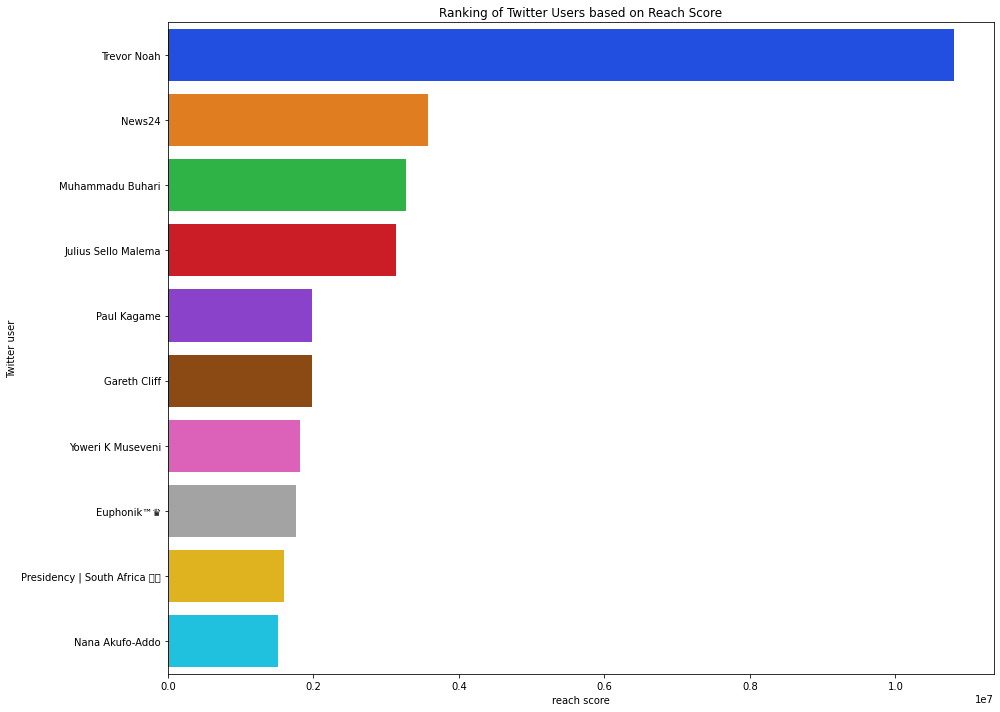

In [ ]:
# plotting the bar chart
fig_dims = (14, 10)
fig, ax = plt.subplots(figsize = fig_dims)

reach_plot = sns.barplot(y = 'user', x ='reach_score', data = highest_reach, palette = 'bright',
           orient = 'h', ax = ax)
reach_plot.set(title = "Ranking of Twitter Users based on Reach Score",
              ylabel = "Twitter user", xlabel = "reach score")

plt.tight_layout()
fig = reach_plot.get_figure()
fig.savefig("reach_score.png")
plt.show()

### Ranking by Popularity Score

In [2]:
# get popularity score per tweet
tweets_df['popularity_score'] = tweets_df['retweets'] + tweets_df['favorites']
tweets_df.head()

,user,text,hashtags,user_mentions,retweets,favorites,popularity_score
0,Jeffrey Gettleman,RT @timesofindia: Ladakh: Indian paratroopers ...,[],"[{'screen_name': 'timesofindia', 'name': 'The ...",470,0,470
1,Jeffrey Gettleman,What an inspiring interchange. Way to go Luke!...,[],[],1,5,6
2,Jeffrey Gettleman,"It's a fantastic school. Congrats, farmer's so...",[],[],2,29,31
3,Jeffrey Gettleman,"RT @ndtv: 99 Doctors Died Due To COVID-19, Say...",[],"[{'screen_name': 'ndtv', 'name': 'NDTV', 'id':...",112,0,112
4,Jeffrey Gettleman,RT @shaikubaid: Specter of Caste in Silicon Va...,[],"[{'screen_name': 'shaikubaid', 'name': 'Shaik ...",3,0,3


In [ ]:
# get the total popularity score per user
pop_score = tweets_df[['user', 'popularity_score']]
total_pop_score = pop_score.groupby('user').sum()
total_pop_score

,popularity_score
user,
#Entrepreneurship #Solutions,533
5FM,1240
A24 Media,187
Abdalla Hamdok,103941
Abdi Aynte,5280
Africa Check,460
Africa Gathering,27868
Africa Research Inst,1296
Africa Team,1


In [ ]:
# getting the top 10 users with highest popularity scores
top_10_pop_score = total_pop_score.popularity_score.sort_values(ascending = False)[:10]
highest_pop = pd.DataFrame(top_10_pop_score).reset_index()
highest_pop

,user,popularity_score
0,Trevor Noah,2343430
1,Jendayi E Frazer,616539
2,Nana Akufo-Addo,344901
3,Paul Kagame,255227
4,Kate Forbes,201952
5,Mbuyiseni Ndlozi,123613
6,Mike Stopforth,118311
7,Jeffrey Gettleman,117905
8,Mary Harper,111681
9,Abdalla Hamdok,103941


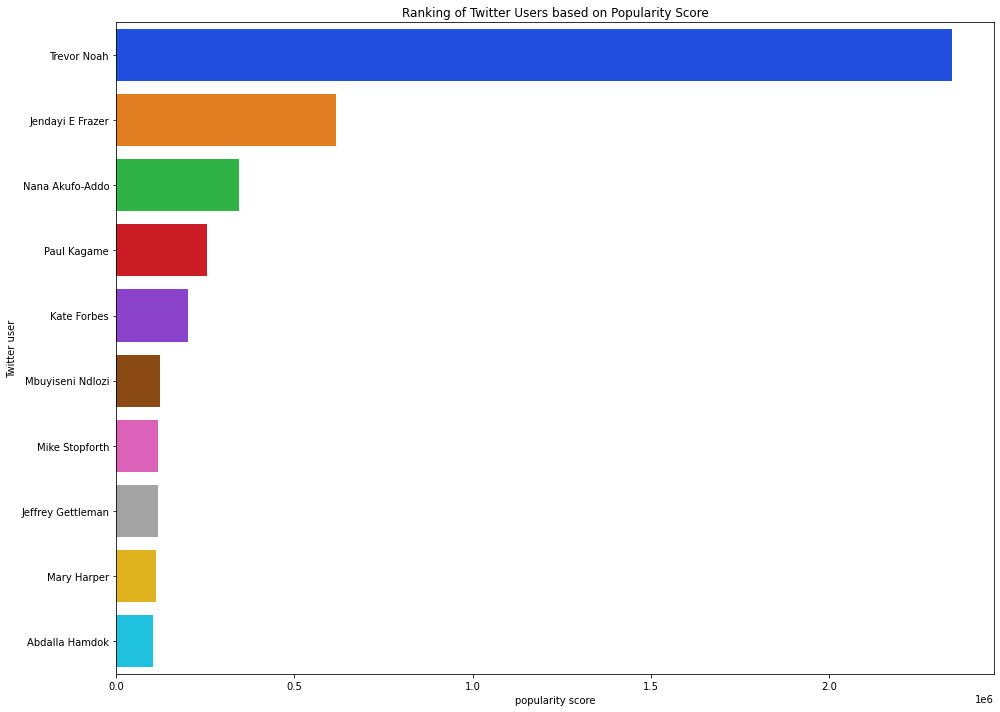

In [ ]:
# plotting the bar chart
fig_dims = (14, 10)
fig, ax = plt.subplots(figsize = fig_dims)

reach_plot = sns.barplot(y = 'user', x ='popularity_score', data = highest_pop, palette = 'bright',
           orient = 'h', ax = ax)
reach_plot.set(title = "Ranking of Twitter Users based on Popularity Score",
              ylabel = "Twitter user", xlabel = "popularity score")

plt.tight_layout()
fig = reach_plot.get_figure()
fig.savefig("popularity_score.png")
plt.show()

### Top 5 Hashtags

In [4]:
# really long unnecessary method to extract hashtags :)
hashtags_list = []
for hashtag in tweets_df['hashtags']:
    hashtags_list.append(hashtag)
    
new_hashtags =[]
for item in hashtags_list:
    new_hashtags.append(item.replace('[', '').replace(']', ''))

for item in new_hashtags:
    if item == '':
        new_hashtags.remove(item)

for item in new_hashtags:
    item.split(',')
    
split_hashtags = []
for item in new_hashtags:
    split_hashtags.append(item.split(','))
    
split_new = []
for item in range(len(split_hashtags)):
    split_new.append(split_hashtags[item][0])
    
split_final = []
for item in split_new:
    split_final.append(item.split(':'))

In [5]:
hashtags = pd.DataFrame(split_final)
hashtags.drop(columns = [0], inplace = True)
hashtags.columns = ['hashtags']
hashtags

,hashtags
0,'PLA'
1,'COVID19'
2,'GalwanValley'
3,'InternationalYogaDay'
4,'coronavirus'
...,...
3592,'Lassa'
3593,'Team228'
3594,'concours'
3595,None


In [6]:
top_10_hashtags = pd.DataFrame(hashtags.hashtags.value_counts().sort_values(ascending = False)[:10])
top_10_hashtags.reset_index(inplace = True)
top_10_hashtags.columns = ['hashtags', 'count']
top_10_hashtags

,hashtags,count
0,'COVID19',182
1,'MandelaDay2020',39
2,'JoburgEnterprises',30
3,'RDC',29
4,'LiveAMP',28
5,'MandelaDay',25
6,'Ramaphosa',23
7,'coronavirus',22
8,'Africa',17
9,'Ethiopia',17


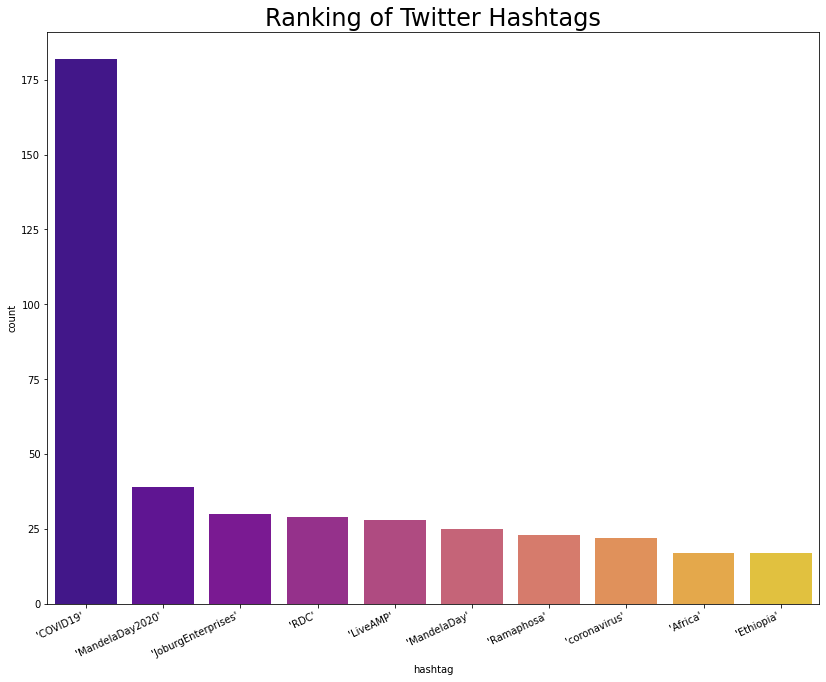

In [9]:
# plotting the bar chart
fig_dims = (12, 10)
fig, ax = plt.subplots(figsize = fig_dims)


hashtags_plot = sns.barplot(x = 'hashtags', y ='count', data = top_10_hashtags, palette =("plasma"),
           orient = 'v', ax = ax)
sns.set_context("poster")
hashtags_plot.set(title = "Ranking of Twitter Hashtags", xlabel = "hashtag")
hashtags_plot.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha ='right')

plt.tight_layout()
fig = hashtags_plot.get_figure()
fig.savefig("hashtags.png")
plt.show()

# Conclusion
Nike should target Twitter users with high popularity scores. The top 5 in order from highest to lowest popularity scores are:
- Trevor Noah
- Jendayi E Frazer
- Nana Akufo-Addo
- Paul Kagame
- Kate Forbes

With the pandemic still ongoing and many countries being in lockdown, Nike can have their campaigns align with the Covid-19 narrative.